<a href="https://colab.research.google.com/github/MagMueller/Predict_Superconductivity_with_FastAi/blob/main/Predict_Superconductivity_with_FastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Superconductivity is a quantum phenomenon that leads to zero resistance in conductors. So far, we only know matrials that have to be under high pressure or at very low temperatures. Thus, to reach the full potential for our power grid or new quantum devices, we need to find a superconductor at room temperature. 
In this notebook, we will first predict the superconducting temperature of different materials and then find new elements and observe their superconducting temperature with the first model to investigate new matrial combinations. 

## Setup


In [1]:
#!pip install fastai --upgrade

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from fastai.tabular import *
from fastai.tabular.all import *
from fastai import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

## Load and inspect Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The 2 Dataset can be downloaded here: https://archive.ics.uci.edu/ml/datasets/superconductivty+data 

You can upload it directly to colab or go like us over google drive.

In [4]:
df = pd.read_csv("drive/MyDrive/developer/superconduct/train.csv")
df_atoms = pd.read_csv("drive/MyDrive/developer/superconduct/unique_m.csv")

In [5]:
df['critical_temp'].describe()

count    21263.000000
mean        34.421219
std         34.254362
min          0.000210
25%          5.365000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

Text(0, 0.5, 'critical temp. (K)')

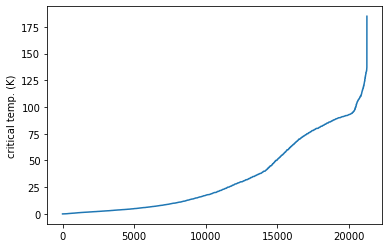

In [6]:
# plot all critical tempretures to see to distribution. Y axis is in celvin:
critical_temp = df['critical_temp'].to_numpy()
critical_temp.sort()

plt.plot(critical_temp)
plt.ylabel('critical temp. (K)')

# I. Use Dataset with properties as mass, radius, entropy ect.

## Preprocessing 

In [8]:
# create dataset for fastai
train, test = train_test_split(df, test_size=0.06)

cont_names = train.columns[:-1].tolist()
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.1)(range_of(train))

dls = TabularDataLoaders.from_df(train, procs=procs, path='.', cat_names=[], cont_names=cont_names, y_names="critical_temp", splits=splits, bs=64)

In [9]:
dls.show_batch()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,5.0,92.940720,51.676555,72.279358,35.060368,1.431655,1.353242,142.925949,20.149229,51.233601,44.893024,749.000001,1003.337528,703.350770,937.106993,1.541260,0.902323,810.599978,703.552311,292.996948,342.738798,176.600006,114.618462,153.055740,89.718041,1.504038,1.381573,205.000001,37.538460,73.442764,79.340257,5032.485840,2975.520215,1105.588699,66.591166,1.315509,0.872394,8958.571284,2066.922857,3271.784916,3660.492674,72.089996,109.294769,53.116081,86.808396,1.357429,0.774963,127.050003,76.413849,50.111042,49.272938,8.704400,5.246615,4.913699,1.336475,1.396425,1.087199,12.878000,2.956615,4.548107,5.644730,89.205315,96.362008,8.142276,1.093363,0.443636,0.204316,399.973416,92.293381,155.528809,166.458664,2.400000,2.076923,2.352158,2.063362,1.589027,1.232797,1.0,1.058462,0.489898,0.266469,0.740000
1,4.0,96.451653,57.593666,69.689339,36.845229,1.158346,1.336725,152.934814,12.644372,60.166150,53.634944,787.400024,1000.147886,733.544312,932.929386,1.312123,0.889354,810.599978,658.725958,315.709044,344.906369,167.000000,115.619782,140.611450,90.266464,1.254609,1.343378,205.000001,21.947451,79.161225,80.274689,5447.857423,3340.797387,804.480972,71.476495,1.023422,0.923347,9318.571300,2076.513418,3897.034407,4008.540279,82.337501,110.591186,60.721493,89.771262,1.164013,0.804915,127.050003,74.037865,51.125721,47.276306,9.530500,5.690933,4.446373,1.389105,1.085789,1.084865,16.577999,2.918031,6.216461,6.255309,108.756645,96.845787,7.552385,1.115367,0.336262,0.203137,399.973416,92.721451,168.301038,166.696094,2.250000,2.077280,2.213364,2.063661,1.368922,1.204247,1.0,0.840804,0.433013,0.267035,74.300003
2,2.0,157.700192,174.793594,149.129790,166.882750,0.639304,0.504457,102.560402,103.846930,51.280201,48.347435,753.200012,736.433346,751.518554,734.949767,0.690916,0.655512,100.600003,200.766669,50.299993,47.423290,156.000000,151.666672,155.457382,151.188796,0.689671,0.659712,26.000000,39.000000,13.000001,12.256518,10901.499932,10527.666837,10843.659192,10476.836682,0.687846,0.664396,2243.000240,2512.333262,1121.499946,1057.360309,73.949997,80.199997,71.533485,77.988907,0.660650,0.538582,37.499999,43.400002,18.749999,17.677670,13.800000,12.833333,13.491849,12.565791,0.670901,0.684348,5.800001,1.700000,2.900000,2.734146,39.500002,28.999999,23.832750,16.563270,0.327855,0.477268,62.999996,18.333334,31.500002,29.698483,4.500000,4.666666,4.472136,4.641589,0.686962,0.598270,1.0

## Training

SuggestedLRs(valley=0.028840314596891403)

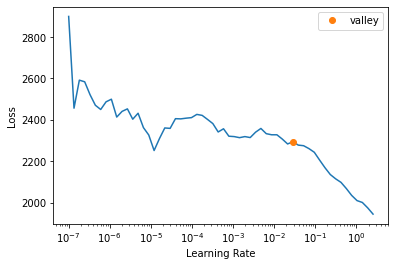

In [ ]:
#Initializing the network
learn = tabular_learner(dls, layers=[200, 100, 50], metrics= [rmse])
learn.lr_find(start_lr = 1e-07,end_lr = 1e+06, num_it = 100)


In [ ]:
#Fitting data and training the network
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,_rmse,time
0,2159.315430,2135.083496,46.206966,00:02
1,1630.145752,1579.771729,39.746346,00:02
2,1003.274597,922.079590,30.365757,00:02
3,535.324158,477.781036,21.858204,00:02
4,386.480743,392.382446,19.808645,00:02
5,355.874542,366.937775,19.155622,00:03
6,347.482422,364.473206,19.091181,00:04
7,348.057861,355.429565,18.852837,00:02
8,326.849701,350.520874,18.722204,00:02
9,310.917542,349.705597,18.700417,00:02


## Evaluation 

In [ ]:
#Display Predictions On Training Data
learn.show_results(ds_type="Train")
#Display Predictions On Validation Data
learn.show_results(ds_type="Valid")

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,critical_temp_pred
0,-0.080772,-0.374298,-0.610834,-0.384415,-0.616218,0.093544,0.551193,0.099385,-0.685301,-0.033967,0.144270,0.278630,0.846860,0.051734,0.774359,0.041221,-0.030632,0.769590,0.678374,0.875512,0.934406,0.327654,-0.611376,-0.244467,-0.813435,-0.029496,0.502774,0.974954,-0.794664,1.131945,1.079603,-0.661204,-0.685874,-0.755249,-0.767259,-0.164741,-0.137058,0.067424,-0.316608,-0.137736,0.206001,0.013527,0.474502,-0.027832,0.399319,0.100976,0.041636,0.110570,0.440343,0.274999,0.272455,-0.540355,-0.589907,-0.604352,-0.664775,0.048560,0.332326,-0.402929,-0.456635,-0.387488,-0.279468,0.494907,0.406561,-0.651121,-0.648122,-1.198018,-1.062604,0.937766,0.784496,1.152416,1.131396,-0.907929,-0.900099,-0.806255,-0.841679,0.185894,0.441707,-0.834039,-0.697249,-0.835037,-0.881663,7.700000,8.678688
1,0.612491,-0.143924,-0.424062,-0.379565,-0.620343,0.399985,0.769556,1.411814,-0.307827,1.136057,1.124646,0.116606,0.966027,0.035966,0.965120,0.663956,0.250867,0.619278,0.824074,0.550475,0.852990,-0.403896,-1.012786,-0.497937,-0.978632,0.669573,1.082747,0.469967,-1.006814,0.306062,0.549369,-0.537999,-0.729746,-0.699714,-0.770965,0.261768,0.759923,0.268061,-0.677904,0.346667,0.397357,-0.136026,0.410145,-0.730890,-0.104708,0.379590,0.176538,0.308764,0.604101,0.405118,0.400296,-0.542836,-0.627559,-0.544004,-0.674963,0.795957,1.302495,-0.402929,-0.582952,-0.455329,-0.336803,1.009805,-0.215717,-0.453889,-0.656361,0.446187,0.746745,0.937766,-0.212524,0.914649,0.638787,-0.573116,-0.634087,-0.625887,-0.678371,0.568248,0.809004,0.771485,-0.551094,0.743744,0.743532,75.985001,8.583373
2,0.612491,0.271567,-0.485988,0.068489,-0.597299,0.695576,1.046671,0.753773,-0.701399,0.528497,0.562215,-0.312092,0.902932,-0.539662,0.847253,0.625313,0.043982,0.769590,0.887613,0.738282,0.922823,0.969628,-0.677644,0.421118,-0.854662,0.627582,0.907028,0.974954,-0.690618,0.969108,1.045487,-0.626399,-0.665742,-0.678946,-0.768627,0.601623,0.252860,0.067424,-0.337868,-0.181028,0.265122,-0.350152,0.540747,-0.533385,0.466494,0.485426,0.131148,0.263238,0.576851,0.276746,0.175580,-0.608871,-0.618898,-0.580384,-0.672656,0.780180,0.535473,-0.402929,-0.463436,-0.483315,-0.312152,0.226382,0.404391,-0.517446,-0.648280,-0.146563,-0.744691,0.937766,0.732429,0.871728,1.095928,-0.955759,-0.901673,-0.848673,-0.843016,0.758292,0.608011,-0.834039,-0.491104,-0.902991,-0.888043,5.500000,7.914657
3,-0.774036,-0.626893,

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,critical_temp_pred
0,-1.467299,-0.428593,0.242753,-0.342836,0.225881,-1.793996,-1.539715,-0.515887,0.793688,-0.031729,0.090552,1.032523,-0.223111,1.392901,-0.061427,-1.625230,-0.708671,-0.871229,-2.023286,-0.584260,-0.581247,-1.812257,-0.344752,-1.144416,0.044052,-1.578449,-1.214693,-1.371751,-0.296444,-1.226691,-1.152031,-0.544288,-0.096373,0.053846,0.232750,-1.667038,-1.315951,-0.781999,0.208907,-0.407931,-0.382491,0.498331,0.020096,1.189510,0.608666,-1.157295,-0.475606,-1.442631,-0.988825,-1.420559,-1.301289,-0.925309,-0.672814,-0.793927,-0.582570,-2.144927,-1.834490,-0.722455,-0.394399,-0.591793,-0.624397,-1.454277,-0.948342,-0.755838,-0.531352,-2.158423,-1.644761,-1.161691,-0.552910,-1.091982,-0.994410,1.244442,1.071804,1.350672,1.147183,-1.547123,-0.954577,-0.834039,-1.374582,-0.697149,-0.393983,22.00,60.679714
1,0.612491,-0.775465,0.093435,-0.826809,-0.031056,0.391214,0.293799,0.464301,0.195582,0.344600,0.488236,3.313940,0.340460,3.210386,0.350884,0.634394,1.800048,1.659175,-1.253368,1.607996,0.591505,-1.956577,0.095302,-2.178241,-0.082036,0.421717,0.397403,0.767018,0.152081,0.856511,0.597738,-0.638160,0.033972,-0.870776,-0.571616,0.051138,0.726359,-0.191692,-0.390184,0.103539,-0.065162,1.705234,-0.372882,0.890414,-0.441775,0.503128,2.436610,3.281155,-1.194457,2.855151,1.166949,-0.344731,-0.063046,-0.712322,-0.358978,-0.104984,0.311663,0.312792,-0.109781,0.216198,0.293941,-1.599733,-1.022368,-0.813719,-0.534170,0.513241,1.108652,-1.084763,-0.979473,-1.124468,-1.019107,-0.381794,0.046570,-0.571208,-0.054200,0.504770,0.828318,1.574247,-0.277229,1.004443,1.046316,78.00,83.670174
2,-0.774036,3.124680,2.831129,3.385552,2.854831,-0.243783,-0.925153,-0.664913,2.560840,-0.381095,-0.091274,-0.520398,-0.547551,-0.285634,-0.372498,-0.557143,-0.668670,-0.945254,-0.221042,-0.921010,-1.146495,-0.675948,0.130568,-0.039929,0.465292,-0.464932,-1.032926,-1.579687,0.707455,-1.593108,-1.458721,1.309829,1.100648,1.622497,1.341113,-0.027160,-0.548939,-0.751904,1.129760,-0.533953,-0.483924,0.221816,0.669179,-0.061076,0.359553,-1.107847,-1.150930,0.862782,1.291654,1.306059,1.632420,-0.483605,-0.189773,-0.306428,-0.076054,-0.583783,-1.049806,-0.382242,0.052663,-0.249803,-0.183839,-1.600015,-1.371980,-0.377280,-0.423950,0.266862,-0.668014,-1.311421,-1.038815,-1.343886,-1.260728,1.085007,1.548312,1.052770,1.566219,-0.604471,-0.968910,0.771485,1.558285,0.840941,0.720534,22.00,66.1

In [ ]:
targets  = []
predictions = []
#test = test.reset_index()  # make sure indexes pair with number of rows
for index, sample in test[:100].iterrows():
  target = sample[-1]
  targets.append(target)
  #print(sample)
  #print(sample[:-1])
  _, clas, _ = learn.predict(sample[:-1])
  #row.show()
  predictions.append(clas)

#eval
predictions = [float(x) for x in predictions]
mse = mean_squared_error(predictions, targets)
p_sort,t_sort = zip( *sorted( zip(predictions, targets)))
eval_df = pd.DataFrame({'critical_temp': targets, 'critical_temp_pred': predictions })

corr, _ = pearsonr(targets, predictions)
print('Pearsons correlation: %.3f' % corr)
print('mse: %.3f' % mse)

Pearsons correlation: 0.876
mse: 253.513


The model predicts the data more or less correct, high values get most often high values and same for low values. There are only a few values which are far away from their actual value.

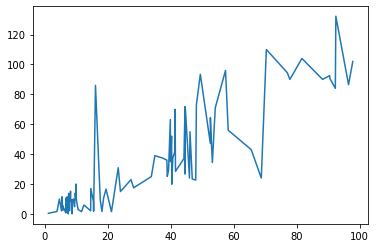

In [ ]:
# plot target vs predicted temp.
plt.plot(p_sort,t_sort)

In [ ]:
eval_df

,critical_temp,critical_temp_pred
0,9.40,17.657869
1,7.44,7.829316
2,10.30,10.018368
3,84.00,92.263596
4,1.60,21.225756
...,...,...
95,25.00,33.867752
96,2.10,14.618575
97,94.50,77.014816
98,17.50,28.235905


# II. Dataset with just number of elements

Later when we want to predict the temp. for new elements we maybe don't have all the information we have right now, but just how many elements we use from each element and therefore we repeat the same task, but with a different underlying data frame.

## Preprocessing 

In [ ]:
train_a, test_a = train_test_split(df_atoms, test_size=0.06)
procs_a = [FillMissing]
cont_names_a = train_a.columns[:-2].tolist()
splits_a = RandomSplitter(valid_pct=0.04)(range_of(train_a))

dls_a = TabularDataLoaders.from_df(train_a, procs=procs_a, path='.', cat_names=[], cont_names=cont_names_a, y_names="critical_temp", splits=splits_a, bs=64)


## Training 


In [ ]:
load = False
if load:
  learn_a = load_learner('drive/MyDrive/developer/superconduct/models/model.pkl')
else:
  #Initializing the network
  learn_a = tabular_learner(dls_a, layers=[86, 172, 86], metrics= [rmse])
  learn_a.lr_find(start_lr = 1e-06,end_lr = 1e+05, num_it = 100)
  #Fitting data and training the network
  learn_a.fit_one_cycle(20)
  # export model
  learn_a.export('drive/MyDrive/developer/superconduct/models/model.pkl')
  #Display Predictions On Training Data
  learn_a.show_results(ds_type="Train")
  #Display Predictions On Validation Data
  learn_a.show_results(ds_type="Valid")

## Evaluation 

In [ ]:
# same eval as before
"""
targets_a  = []
predictions_a = []
#test = test.reset_index()  # make sure indexes pair with number of rows
for index, sample in test_a[:50].iterrows():
  target = sample[-2]
  targets_a.append(target)
  #print(sample)
  #print(sample[:-1])
  _, clas, _ = learn_a.predict(sample[:-2])
  #row.show()
  predictions_a.append(clas)

#eval
predictions_a = [float(x) for x in predictions_a]
mse_a = mean_squared_error(predictions_a, targets_a)
p_sort_a,t_sort_a = zip( *sorted( zip(predictions_a, targets_a)))
eval_df_a = pd.DataFrame({'critical_temp': targets_a, 'critical_temp_pred': predictions_a })


corr_a, _ = pearsonr(targets_a, predictions_a)
print('Pearsons correlation: %.3f' % corr_a)
print('Mean squared error: %.3f' % mse_a)
"""

"\ntargets_a  = []\npredictions_a = []\n#test = test.reset_index()  # make sure indexes pair with number of rows\nfor index, sample in test_a[:50].iterrows():\n  target = sample[-2]\n  targets_a.append(target)\n  #print(sample)\n  #print(sample[:-1])\n  _, clas, _ = learn_a.predict(sample[:-2])\n  #row.show()\n  predictions_a.append(clas)\n\n#eval\npredictions_a = [float(x) for x in predictions_a]\nmse_a = mean_squared_error(predictions_a, targets_a)\np_sort_a,t_sort_a = zip( *sorted( zip(predictions_a, targets_a)))\neval_df_a = pd.DataFrame({'critical_temp': targets_a, 'critical_temp_pred': predictions_a })\n\n\ncorr_a, _ = pearsonr(targets_a, predictions_a)\nprint('Pearsons correlation: %.3f' % corr_a)\nprint('Mean squared error: %.3f' % mse_a)\n"

In [ ]:
# create predictions, more efficient than the previous approach
test_dl = learn_a.dls.test_dl(test_a)
predictions_a, _ = learn_a.get_preds(dl=test_dl)

predictions_a = pd.Series(predictions_a.numpy().flatten()).values
targets_a = test_a['critical_temp']

In [ ]:
mse_a = mean_squared_error(predictions_a, targets_a)
p_sort_a,t_sort_a = zip( *sorted( zip(predictions_a, targets_a)))
eval_df_a = pd.DataFrame({'critical_temp': targets_a, 'critical_temp_pred': predictions_a })


corr_a, _ = pearsonr(targets_a, predictions_a)
print('Pearsons correlation: %.3f' % corr_a)
print('Mean squared error: %.3f' % mse_a)

Pearsons correlation: 0.884
Mean squared error: 276.031


(0.0, 135.0)

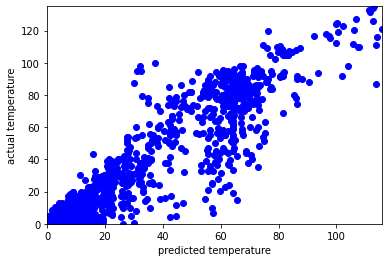

In [ ]:
plt.plot(p_sort_a,t_sort_a, 'bo')
plt.ylabel("actual temperature")
plt.xlabel("predicted temperature")
plt.xlim(0, max(predictions_a))
plt.ylim(0, max(targets_a))
#fig.subplots_adjust(top=0.8)
#ax1 = fig.add_subplot(211)
#ax1.set_ylabel('actual temperature')
#ax1.set_title('Predictions from just atomos')

There is still a high correlation between the predictions and the targets, so the model did a good job. Now we can move on and try to find new materials.

# III. Artificial Dataset to make predictictions for new materials

## Create random new compounds by sampling elements from existing Dataframe 

In [ ]:
col = train_a.columns[:-2]
n_values = int(1e6) # amount of new elements
fake_data = pd.DataFrame(data=np.zeros((n_values,len(col))), columns=col)

In [ ]:
for (columnName, columnData) in (train_a[col].iteritems()):
  values = np.array(columnData.values) 
  
  # more varriation
  #normal = abs(np.random.randn(*values.shape) * .5 + 1.5)
  
  # special case O, Ca, Cu
  # replace 0 with samples
  if columnName in ['O','Ca','Cu']:
    # these elements should be used more often
    #mask = values == 0
    non_zero_values = values[values != 0]
    values = np.random.choice(non_zero_values, values.shape)
  # create a weight vector to variate the inital previous elements
  # change this vector for more/less variation
  weight = (np.random.choice([0.5,1,1.5,2], values.shape, p=[0.1,0.7,0.1,0.1])) 
  fake_data[columnName] = np.random.choice(values * weight, n_values)

In [ ]:
# drop out all null rows
fake_data = fake_data.loc[~(fake_data==0).all(axis=1)]
#fake_data.describe()

In [ ]:
#train_a.describe()

## Predict with fake data

In [ ]:
# previous evaluation
"""
def find_new_materials(data, learner, n):
  #targets = []
  predictions = []
  n = min(n, len(data))
  data = data.sample(n)
  #test = test.reset_index()  # make sure indexes pair with number of rows
  for i,(_, sample) in enumerate(data.iterrows()):
    if i % (n//10) == 0: print('sample %.f'%i)
    #target = sample[-2]

    #print(sample)
    #print(sample[:-1])
    _, clas, _ = learner.predict(sample)
    #row.show()
    predictions.append(clas)
    #pdb.set_trace()
    #break

  #eval
  predictions = np.array([float(x) for x in predictions])
  #mse_a = mean_squared_error(predictions_a, targets_a)
  #p_sort_a,t_sort_a = zip( *sorted( zip(predictions_a, targets_a)))
  #print(pd.Series(predictions, index=data.index))
  #data['predictions'] = pd.Series(predictions, index=data.index)
  data = data.assign(predictions=pd.Series(predictions).values)
  return data
  

  #corr_a, _ = pearsonr(targets_a, predictions_a)
  #print('Pearsons correlation: %.3f' % corr_a)
  #print('Mean squared error: %.3f' % mse_a)
result = find_new_materials(fake_data, learn_a, n=200)
"""

"\ndef find_new_materials(data, learner, n):\n  #targets = []\n  predictions = []\n  n = min(n, len(data))\n  data = data.sample(n)\n  #test = test.reset_index()  # make sure indexes pair with number of rows\n  for i,(_, sample) in enumerate(data.iterrows()):\n    if i % (n//10) == 0: print('sample %.f'%i)\n    #target = sample[-2]\n\n    #print(sample)\n    #print(sample[:-1])\n    _, clas, _ = learner.predict(sample)\n    #row.show()\n    predictions.append(clas)\n    #pdb.set_trace()\n    #break\n\n  #eval\n  predictions = np.array([float(x) for x in predictions])\n  #mse_a = mean_squared_error(predictions_a, targets_a)\n  #p_sort_a,t_sort_a = zip( *sorted( zip(predictions_a, targets_a)))\n  #print(pd.Series(predictions, index=data.index))\n  #data['predictions'] = pd.Series(predictions, index=data.index)\n  data = data.assign(predictions=pd.Series(predictions).values)\n  return data\n  \n\n  #corr_a, _ = pearsonr(targets_a, predictions_a)\n  #print('Pearsons correlation: %.3f' % co

In [ ]:
# create predictions
test_dl = learn_a.dls.test_dl(fake_data)
predictions, _ = learn_a.get_preds(dl=test_dl)

predictions = pd.Series(predictions.numpy().flatten()).values

fake_data = fake_data.assign(predictions= predictions)
print(fake_data['predictions'].describe())
print()
fake_data = fake_data.sort_values(by='predictions', ascending=False)
# print max tempreture
#result['predictions'].idxmax()
highest_temp = fake_data.loc[fake_data['predictions'].idxmax()]
highest_temp[highest_temp>0]

count    1000000.000000
mean          40.134357
std           23.952740
min         -721.353943
25%           24.779832
50%           36.364189
75%           55.193825
max          142.553452
Name: predictions, dtype: float64



O                2.000000
Ca               3.000000
Cu               3.920000
Ga               0.150000
Ag               5.000000
Ba               3.600000
Hg               1.200000
Pb               0.400000
predictions    142.553452
Name: 793359, dtype: float64

In [ ]:
fake_data.head()

,index,H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,predictions
0,793359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.92,0.0,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.00,0.0,1.2,0.0,0.4,0.0,0.0,0.0,0.0,142.553452
1,133840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.50,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.15,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,137.442490
2,204140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,136.861954
3,271286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0375,0.0,0.00,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,136.795578
4,869118,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0000,0.0,0.00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,134.683609


In [ ]:
range(len(fake_data['predictions']))

range(0, 1000000)

In [ ]:
#fake_data=fake_data.reset_index()

(120.0, 142.55345153808594)

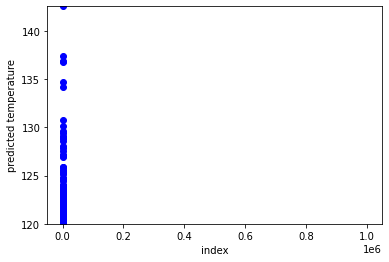

In [ ]:
# plot the best material combinations
plt.plot( fake_data['predictions'], 'bo')
plt.ylabel("predicted temperature")
plt.xlabel("index")
#plt.xlim(0, max(predictions_a))
plt.ylim(120, max(fake_data['predictions']))

In [ ]:
# save csv
fake_data.head(100).to_csv('drive/MyDrive/developer/superconduct/out2.csv')

These are the best combinations, which deserve further observation. Because they are created randomly, many of them will not be realizable in the lab.

## Predict existing single compounds

Here we want to test the model on some new high tempreture superconductors, if it also predicts a high value for them.

In [ ]:

def predict_single(formular, real_temp):
  col = train_a.columns[:-2]
  n_values = 1
  test_single_superconductors = pd.DataFrame(data=np.zeros((n_values,len(col))), columns=col)

  for k, v in formular.items():
    print('{} {}'.format(k,v))
    test_single_superconductors[k] = v
  _,prediction_single,_ = learn_a.predict(test_single_superconductors.iloc[0])
  print(f'prediction: {int(prediction_single)} Kelvin\nreal value: {real_temp} Kelvin\n\n')


In [ ]:
# frome wikipeia: 'Hg12T3Ba30Ca30Cu45O127'
formular = {'Hg':12,
            'Tl': 3,
            'Ba':30,
            'Ca':30,
            'Cu':45,
            'O':127}
real_temp = 138
predict_single(formular, real_temp)  

# frome wikipeia: 'Bi2Sr2Ca2Cu3O10'
formular = {'Bi':2,
            'Sr': 2,
            'Ca':2,
            'Cu':3,
            'O':10}
real_temp = 110
predict_single(formular, real_temp)  



Hg 12
Tl 3
Ba 30
Ca 30
Cu 45
O 127


prediction: 169 Kelvin
real value: 138 Kelvin


Bi 2
Sr 2
Ca 2
Cu 3
O 10


prediction: 71 Kelvin
real value: 110 Kelvin




It really recognizes them as high-temp. superconductors, but there is still a high variance.

## Future investigations
- observe the material predictions in the lab
- combine both data sets
- add iteratively more data with higher values to the data set and do new predictions until you reach room temperature

- use different models 
  - for example reinforcement learning, for the predictions. A approach where your input is a temprutuer and the output is a combination could also be really helpful, because in the end you can just ask for a combination for a critical room temp.
  - the combination generator can also be exchanged. From a random model to a model which includes more chemical properties to avoid combinations which are not feasible
  - GAN architecture can work. There you have one model which tries to create new combinations and another one who tries to predict if a combination is real or not. Little by little, they try to fool each other and get better and better at it. 

# IV. additional Dataset


of course you can also combine more data for training.

In [ ]:
df2 = pd.read_csv("drive/MyDrive/developer/superconduct/Supercon_data.csv")

In [ ]:
df2.describe()